# Import

In [1]:
## Misc
import os
import time
import warnings
import numpy as np
import pandas as pd

# Model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, confusion_matrix

## Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
## Features importance
import shap

## Graphs
import matplotlib.pyplot as plt
import seaborn as sns

## Serialization
import joblib

C:\Users\james\anaconda3\envs\tfp7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Remove temporary files
try:
    os.remove('max_accuracy.jl') 
    print('max_accuracy.jl removed')
except:
    print('max_accuracy.jl does not exist')
    
try:
    os.remove('ts_model.jl') 
    print('ts_model.jl removed')  
except:
    print('ts_model.jl does not exist')   

max_accuracy.jl does not exist
ts_model.jl does not exist


In [3]:
# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Inactivate warnings
warnings.filterwarnings('ignore')

# Data load

In [4]:
data = pd.read_csv('./data/cotations_EDF.csv', sep=';', decimal='.', encoding='utf8', low_memory=False)

In [5]:
data.head()

,isin,date,ouverture,haut,bas,cloture,volume
0,FR0010242511,28/02/2022,7.84,8.146,7.810,8.130,4988984
1,FR0010242511,25/02/2022,7.55,8.044,7.482,7.932,7161356
2,FR0010242511,24/02/2022,7.59,7.590,7.200,7.500,9257738
3,FR0010242511,23/02/2022,8.04,8.080,7.808,7.832,2973088
4,FR0010242511,22/02/2022,7.87,7.996,7.760,7.960,3155739


# Preprocessing

## Format date

In [6]:
data['date'] = pd.to_datetime(data['date'])

## Sort

In [7]:
# Sort dataset from past to present
data.sort_index(axis=0, ascending=False, inplace=True)
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

## Target

In [8]:
data['target'] = (data['cloture'].pct_change().shift(-1) > 0).astype(int)

In [9]:
data.head(10)

,isin,date,ouverture,haut,bas,cloture,volume,target
0,FR0010242511,2006-02-01,31.91,32.10,31.81,32.10,262542,1
1,FR0010242511,2006-03-01,32.10,32.36,32.02,32.36,486574,1
2,FR0010242511,2006-04-01,32.43,33.37,32.42,33.37,2806007,0
3,FR0010242511,2006-05-01,33.40,33.40,32.84,33.29,1731173,1
4,FR0010242511,2006-06-01,33.30,33.33,32.95,33.30,1868319,1
5,FR0010242511,2006-09-01,33.00,33.60,32.95,33.60,1849156,1
6,FR0010242511,2006-10-01,33.55,33.66,33.35,33.62,990494,1
7,FR0010242511,2006-11-01,33.60,34.00,33.60,33.95,1347550,0
8,FR0010242511,2006-12-01,33.82,34.00,33.62,33.87,1119494,1
9,FR0010242511,2006-01-13,34.00,34.92,33.92,34.55,2478719,1


# Feature engineering

In [10]:
# Variations
data['v_ouverture'] = (data['ouverture'].diff() / data['ouverture'].shift(1)) * 100
data['v_bas'] = (data['bas'].diff() / data['bas'].shift(1)) * 100
data['v_cloture'] = (data['cloture'].diff() / data['cloture'].shift(1)) * 100
data['v_volume'] = (data['volume'].diff() / data['volume'].shift(1)) * 100

In [11]:
# Differences
data['d_o_h'] = data['ouverture'] - data['haut']
data['d_o_b'] = data['ouverture'] - data['bas']
data['d_o_c'] = data['ouverture'] - data['cloture']
data['d_h_b'] = data['haut'] - data['bas']

In [12]:
# Number of consecutive increases
data['cons_increase'] = 0
iteration = 0
count = 0

for index, row in data.iterrows():
    iteration += 1
    
    if iteration == 1:
        data['cons_increase'][index] = np.nan
    elif iteration > 1 and iteration < len(data):
        if data['cloture'][index] > data['cloture'][index - 1]:
            count += 1
        else:
            count = 0
                
        data['cons_increase'][index] = count

In [13]:
# Number of consecutive decreases
data['cons_decrease'] = 0
iteration = 0
count = 0

for index, row in data.iterrows():
    iteration += 1
    
    if iteration == 1:
        data['cons_decrease'][index] = np.nan
    elif iteration > 1 and iteration < len(data):
        if data['cloture'][index] < data['cloture'][index - 1]:
            count += 1
        else:
            count = 0
                
        data['cons_decrease'][index] = count

In [14]:
nb_days = [2, 3, 5, 10, 15]

In [15]:
# Moving averages
for days in nb_days:
    data['mm' + str(days)] = 0
    iteration = 0

    for index, row in data.iterrows():
        if iteration < days-1:
            data['mm' + str(days)][index] = np.nan
        else:
            data['mm' + str(days)][index] = data['cloture'][index-(days-1):index+1].sum() / days

        iteration += 1

In [16]:
# Moving exponential averages
for days in nb_days:
    data['mme' + str(days)] = 0
    iteration = 0

    for index, row in data.iterrows():
        if iteration < days:
            data['mme' + str(days)][index] = np.nan
        else:
            data['mme' + str(days)][index] = (
                (data['cloture'][index] - data['mm' + str(days)][index-1]) * (2/(days + 1))) + data['mm' + str(days)][index-1]

        iteration += 1

In [17]:
# MACD 2-x
data['macd_2_5'] = data['mme2'] - data['mme5']
data['macd_2_15'] = data['mme2'] - data['mme15']

In [18]:
# MACD 3-x
data['macd_3_5'] = data['mme3'] - data['mme5']
data['macd_3_15'] = data['mme3'] - data['mme15']

In [19]:
# MACD 5-x
data['macd_5_15'] = data['mme5'] - data['mme15']

## Seasonality

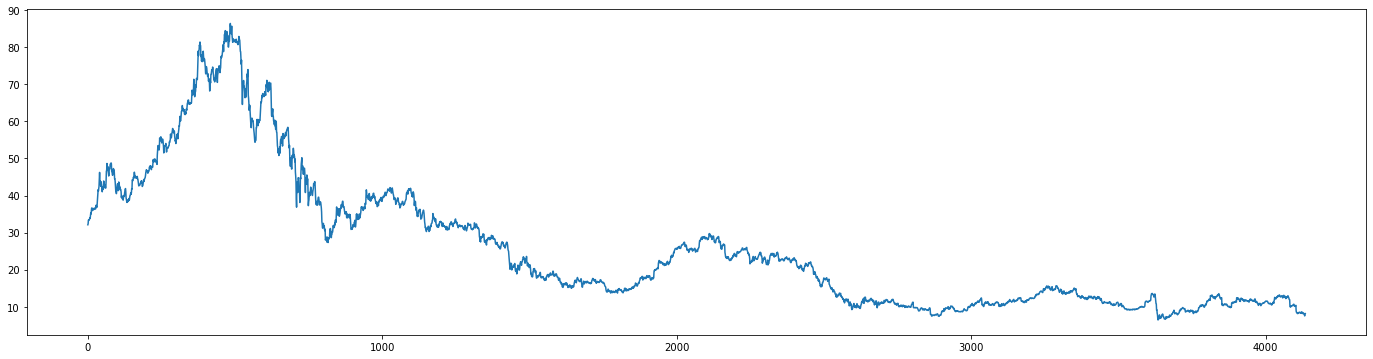

In [20]:
# line plot of dataset
fig = plt.figure(figsize=(24, 6))
data.cloture.plot()
plt.show()

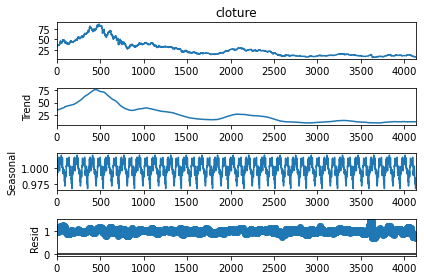

In [21]:
# Seasonality cloture
result = seasonal_decompose(data.cloture, model='multiplicative', period=180, extrapolate_trend='freq')
result.plot()
plt.show()

In [22]:
data['trend'] = result.trend

In [23]:
data['trend_variation1'] = data['trend'].diff()
data['trend_variation3'] = data['trend'].diff(3)
data['trend_variation15'] = data['trend'].diff(15)

In [24]:
# Make stationary
data['cloture_adj'] = data['cloture'].diff(60)

In [25]:
# Adjusted lags
data['lag_2_adj'] = data['cloture_adj'].shift(2)
data['lag_4_adj'] = data['cloture_adj'].shift(4)
data['lag_5_adj'] = data['cloture_adj'].shift(5)

In [26]:
data.head()

,isin,date,ouverture,haut,bas,cloture,volume,target,v_ouverture,v_bas,v_cloture,v_volume,d_o_h,d_o_b,d_o_c,d_h_b,cons_increase,cons_decrease,mm2,mm3,mm5,mm10,mm15,mme2,mme3,mme5,mme10,mme15,macd_2_5,macd_2_15,macd_3_5,macd_3_15,macd_5_15,trend,trend_variation1,trend_variation3,trend_variation15,cloture_adj,lag_2_adj,lag_4_adj,lag_5_adj
0,FR0010242511,2006-02-01,31.91,32.10,31.81,32.10,262542,1,NaN,NaN,NaN,NaN,-0.19,0.10,-0.19,0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.039643,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FR0010242511,2006-03-01,32.10,32.36,32.02,32.36,486574,1,0.595425,0.660170,0.809969,85.331871,-0.26,0.08,-0.26,0.34,1.0,0.0,32.230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.036780,-0.002862,NaN,NaN,NaN,NaN,NaN,NaN
2,FR0010242511,2006-04-01,32.43,33.37,32.42,33.37,2806007,0,1.028037,1.249219,3.121137,476.686588,-0.94,0.01,-0.94,0.95,2.0,0.0,32.865,32.610000,NaN,NaN,NaN,32.990000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.033918,-0.002862,NaN,NaN,NaN,NaN,NaN,NaN
3,FR0010242511,2006-05-01,33.40,33.40,32.84,33.29,1731173,1,2.991058,1.295497,-0.239736,-38.304751,0.00,0.56,0.11,0.56,0.0,1.0,33.330,33.006667,NaN,NaN,NaN,33.148333,32.950000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.031056,-0.002862,-0.008587,NaN,NaN,NaN,NaN,NaN
4,FR0010242511,2006-06-01,33.30,33.33,32.95,33.30,1868319,1,-0.299401,0.334957,0.030039,7.922143,-0.03,0.35,0.00,0.38,1.0,0.0,33.295,33.320000,32.884,NaN,NaN,33.310000,33.153333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.028194,-0.002862,-0.008587,NaN,NaN,NaN,NaN,NaN


# Data exploration

In [27]:
data.columns

Index(['isin', 'date', 'ouverture', 'haut', 'bas', 'cloture', 'volume',
       'target', 'v_ouverture', 'v_bas', 'v_cloture', 'v_volume', 'd_o_h',
       'd_o_b', 'd_o_c', 'd_h_b', 'cons_increase', 'cons_decrease', 'mm2',
       'mm3', 'mm5', 'mm10', 'mm15', 'mme2', 'mme3', 'mme5', 'mme10', 'mme15',
       'macd_2_5', 'macd_2_15', 'macd_3_5', 'macd_3_15', 'macd_5_15', 'trend',
       'trend_variation1', 'trend_variation3', 'trend_variation15',
       'cloture_adj', 'lag_2_adj', 'lag_4_adj', 'lag_5_adj'],
      dtype='object')

## Useless columns

In [28]:
data.drop(['isin', 'date', 'ouverture', 'haut', 'bas',
           'cloture', 'volume', 'mm2', 'mm3', 'mm5',
           'mm10', 'mm15', 'mme2', 'mme3', 'mme5',
           'mme10', 'mme15', 'cloture_adj'], axis=1, inplace=True)

## Target variables

<AxesSubplot:ylabel='target'>

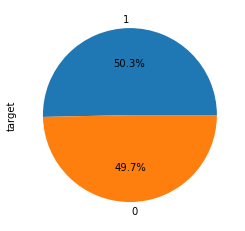

In [29]:
data['target'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [30]:
increase = data[data['target'] == True]

In [31]:
decrease = data[data['target'] == False]

## Rows and columns

In [32]:
data.shape

(4136, 23)

## Missing values

In [33]:
data.isnull().any()

target               False
v_ouverture           True
v_bas                 True
v_cloture             True
v_volume              True
d_o_h                False
d_o_b                False
d_o_c                False
d_h_b                False
cons_increase         True
cons_decrease         True
macd_2_5              True
macd_2_15             True
macd_3_5              True
macd_3_15             True
macd_5_15             True
trend                False
trend_variation1      True
trend_variation3      True
trend_variation15     True
lag_2_adj             True
lag_4_adj             True
lag_5_adj             True
dtype: bool

In [34]:
data = data [data['lag_5_adj'].notna()]

In [35]:
data.isnull().any()

target               False
v_ouverture          False
v_bas                False
v_cloture            False
v_volume             False
d_o_h                False
d_o_b                False
d_o_c                False
d_h_b                False
cons_increase        False
cons_decrease        False
macd_2_5             False
macd_2_15            False
macd_3_5             False
macd_3_15            False
macd_5_15            False
trend                False
trend_variation1     False
trend_variation3     False
trend_variation15    False
lag_2_adj            False
lag_4_adj            False
lag_5_adj            False
dtype: bool

## Increase / decrease

In [36]:
data.columns

Index(['target', 'v_ouverture', 'v_bas', 'v_cloture', 'v_volume', 'd_o_h',
       'd_o_b', 'd_o_c', 'd_h_b', 'cons_increase', 'cons_decrease', 'macd_2_5',
       'macd_2_15', 'macd_3_5', 'macd_3_15', 'macd_5_15', 'trend',
       'trend_variation1', 'trend_variation3', 'trend_variation15',
       'lag_2_adj', 'lag_4_adj', 'lag_5_adj'],
      dtype='object')

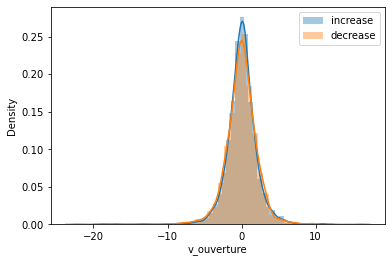

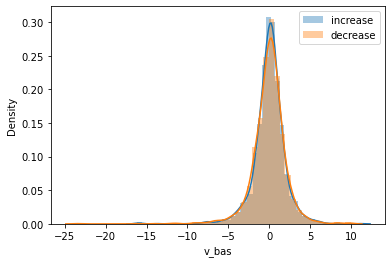

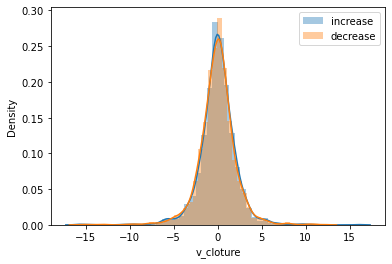

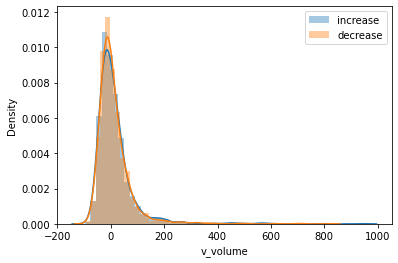

In [37]:
variations = ['v_ouverture', 'v_bas', 'v_cloture', 'v_volume']
for col in variations:
    plt.figure()
    sns.distplot(increase[col], label='increase')
    sns.distplot(decrease[col], label='decrease')
    plt.legend()

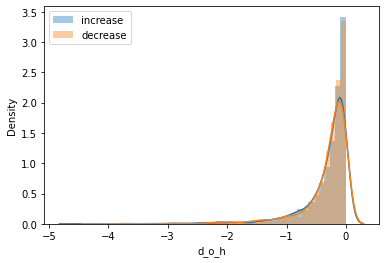

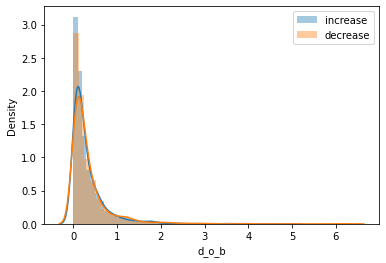

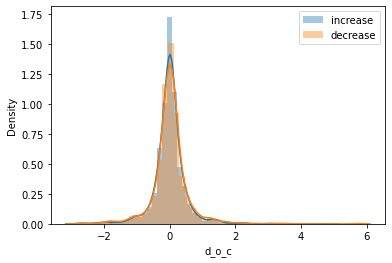

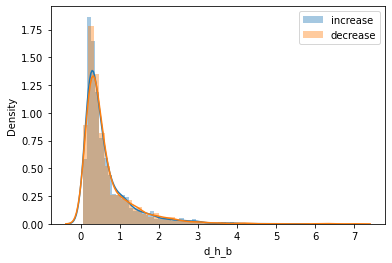

In [38]:
deltas = ['d_o_h', 'd_o_b', 'd_o_c', 'd_h_b']
for col in deltas:
    plt.figure()
    sns.distplot(increase[col], label='increase')
    sns.distplot(decrease[col], label='decrease')
    plt.legend()

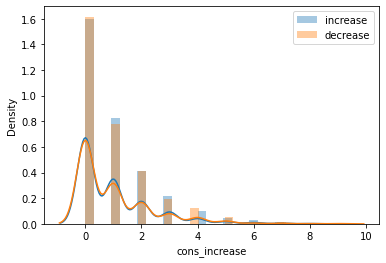

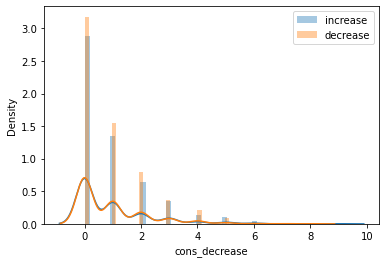

In [39]:
cons = ['cons_increase', 'cons_decrease']
for col in cons:
    plt.figure()
    sns.distplot(increase[col], label='increase')
    sns.distplot(decrease[col], label='decrease')
    plt.legend()

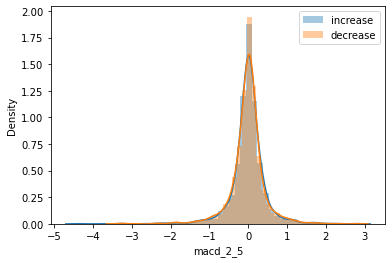

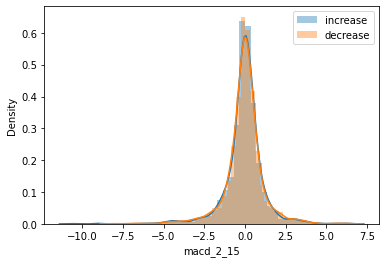

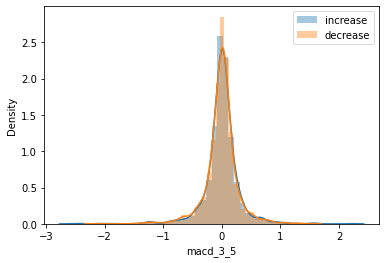

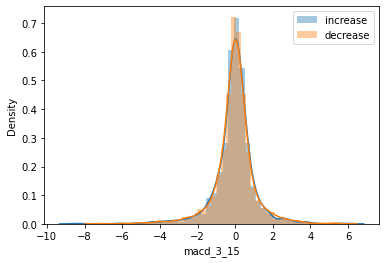

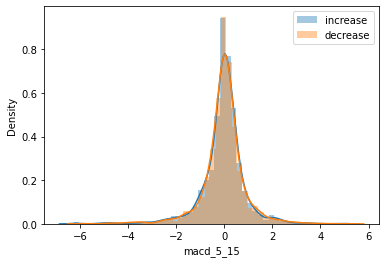

In [40]:
mms = ['macd_2_5', 'macd_2_15', 'macd_3_5', 'macd_3_15', 'macd_5_15']
for col in mms:
    plt.figure()
    sns.distplot(increase[col], label='increase')
    sns.distplot(decrease[col], label='decrease')
    plt.legend()

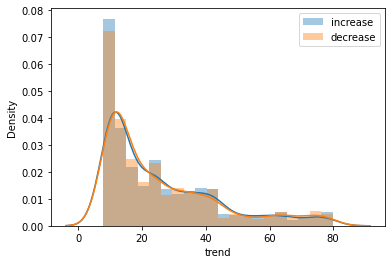

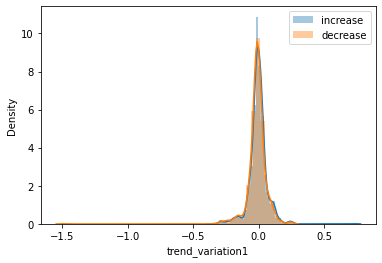

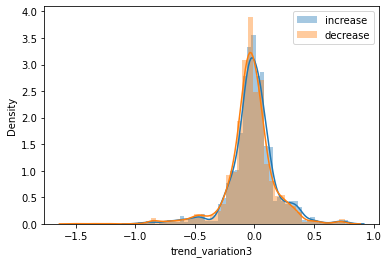

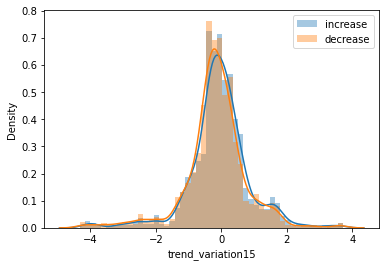

In [41]:
season = ['trend', 'trend_variation1', 'trend_variation3', 'trend_variation15']
for col in season:
    plt.figure()
    sns.distplot(increase[col], label='increase')
    sns.distplot(decrease[col], label='decrease')
    plt.legend()

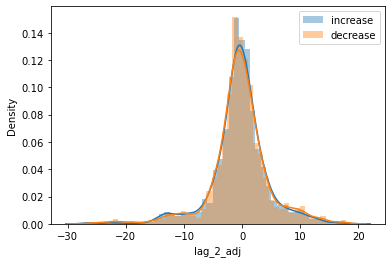

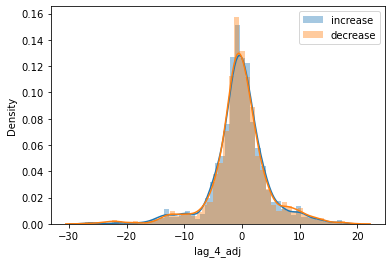

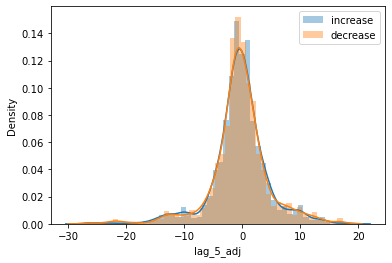

In [42]:
lags = ['lag_2_adj', 'lag_4_adj', 'lag_5_adj']
for col in lags:
    plt.figure()
    sns.distplot(increase[col], label='increase')
    sns.distplot(decrease[col], label='decrease')
    plt.legend()

## Correlation

In [43]:
data.corr()

,target,v_ouverture,v_bas,v_cloture,v_volume,d_o_h,d_o_b,d_o_c,d_h_b,cons_increase,cons_decrease,macd_2_5,macd_2_15,macd_3_5,macd_3_15,macd_5_15,trend,trend_variation1,trend_variation3,trend_variation15,lag_2_adj,lag_4_adj,lag_5_adj
target,1.000000,0.007153,0.004811,0.015691,0.017889,0.007965,-0.018535,-0.017338,-0.018694,-0.006398,0.001069,0.007897,-0.004323,0.005627,-0.006457,-0.009641,-0.005626,0.053367,0.052512,0.052131,-0.005109,-0.003255,-0.003083
v_ouverture,0.007153,1.000000,0.655388,0.306666,-0.053119,0.046840,-0.027911,-0.011393,-0.051604,0.287882,-0.330941,0.417542,0.267729,0.344220,0.212651,0.144396,0.003970,0.072122,0.073767,0.073210,-0.012684,-0.015288,-0.014492
v_bas,0.004811,0.655388,1.000000,0.743258,-0.298223,-0.179307,-0.406124,-0.411728,-0.171464,0.418378,-0.467484,0.419184,0.254014,0.330534,0.193307,0.125499,0.002270,0.074101,0.077483,0.075591,-0.020834,-0.017542,-0.016889
v_cloture,0.015691,0.306666,0.743258,1.000000,-0.115692,-0.371806,-0.452897,-0.675109,-0.075549,0.474140,-0.529658,0.381931,0.225725,0.294224,0.168017,0.106813,0.002261,0.071437,0.074085,0.072000,-0.018607,-0.016831,-0.015473
v_volume,0.017889,-0.053119,-0.298223,-0.115692,1.000000,-0.070428,0.191180,0.089030,0.184927,-0.014296,0.060789,-0.031244,0.001295,-0.013900,0.010565,0.017309,0.013884,0.002778,0.000757,0.009073,0.025222,0.021133,0.016481
d_o_h,0.007965,0.046840,-0.179307,-0.371806,-0.070428,1.000000,-0.030509,0.566851,-0.694994,-0.200906,0.209004,-0.153003,-0.055512,-0.098105,-0.023871,0.003231,-0.583133,0.045597,0.043654,0.035652,0.012614,0.005464,0.002810
d_o_b,-0.018535,-0.027911,-0.406124,-0.452897,0.191180,-0.030509,1.000000,0.694778,0.739885,-0.256445,0.288671,-0.357361,-0.261334,-0.297417,-0.217883,-0.166018,0.474291,-0.253365,-0.258744,-0.254830,-0.115650,-0.107653,-0.107060
d_o_c,-0.017338,-0.011393,-0.411728,-0.675109,0.089030,0.566851,0.694778,1.000000,0.118272,-0.371268,0.418322,-0.438846,-0.277607,-0.347363,-0.215473,-0.146779,-0.012294,-0.149822,-0.154399,-0.152750,-0.043526,-0.039064,-0.040484
d_h_b,-0.018694,-0.051604,-0.171464,-0.075549,0.184927,-0.694994,0.739885,0.118272,1.000000,-0.049254,0.066986,-0.154090,-0.150628,-0.147918,-0.140668,-0.121600,0.733657,-0.212947,-0.215509,-0.207308,-0.091683,-0.081117,-0.078905
cons_increase,-0.006398,0.287882,0.418378,0.474140,-0.014296,-0.200906,-0.256445,-0.371268,-0.049254,1.000000,-0.514134,0.336443,0.220135,0.279316,0.176684,0.122159,-0.010196,0.054321,0.056872,0.052631,0.005072,-0.006292,-0.006131


# Split

In [44]:
# Reset index to ease further treatments
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

In [45]:
# Collect 270 rows for the test dataset
X_test = data.loc[3801:, (data.columns != 'target')]
y_test = data.loc[3801:, (data.columns == 'target')]
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_test (270, 22)
y_test (270, 1)


In [46]:
# Remove these rows from data
data = data.loc[:3800]
data.shape

(3801, 23)

In [47]:
X = data.loc[:, (data.columns != 'target')]
y = data[['target']]
print('X', X.shape)
print('y', y.shape)

X (3801, 22)
y (3801, 1)


# Features importance

In [48]:
scaler = StandardScaler()

In [49]:
model = LogisticRegression(penalty='l1',
                           tol=1e-4,
                           max_iter=100,
                           class_weight='balanced',
                           solver='saga',
                           l1_ratio=0.5,
                           warm_start=False, n_jobs=-1)

In [50]:
pipe = Pipeline(steps =[
        ('scaler', scaler),
        ('model', model)])

In [51]:
tscv = TimeSeriesSplit(n_splits=5)

In [52]:
for train_index, val_index in tscv.split(X):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    pipe.fit(X_train, y_train)

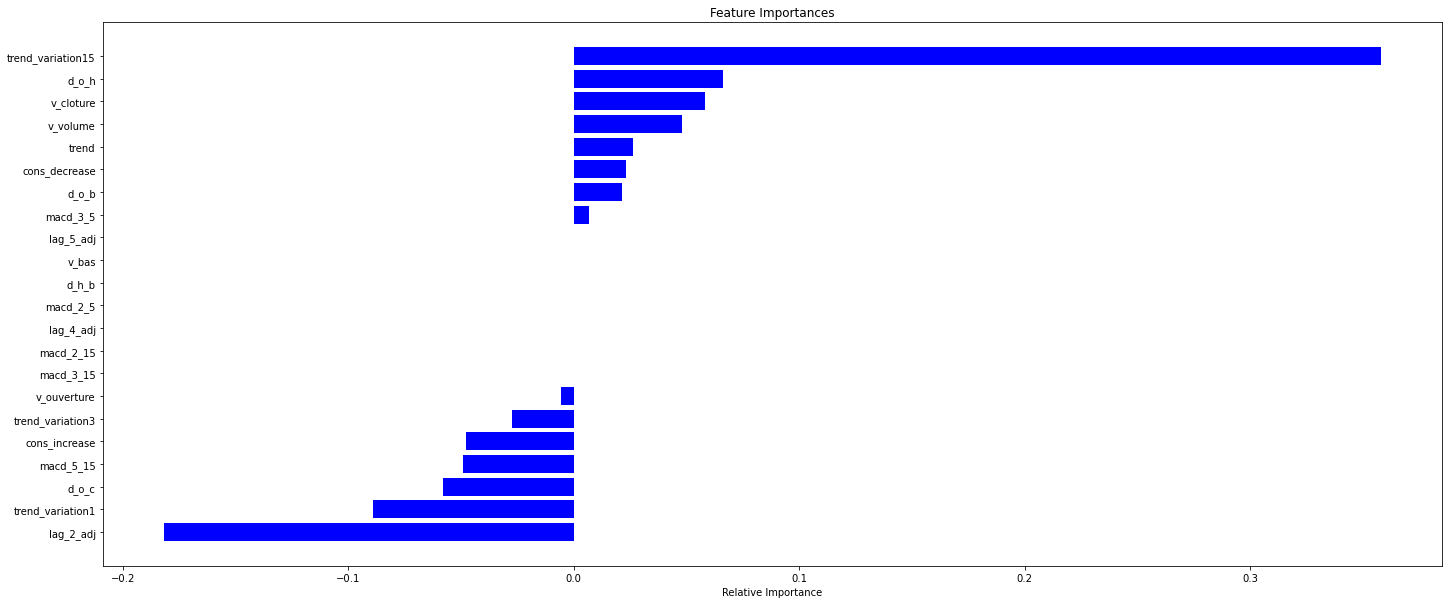

In [53]:
importances = pipe.steps[1][1].coef_[0]
indices = np.argsort(importances)

features = X_train.columns
fig = plt.figure(figsize=(24, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [54]:
# Update with most important variables
X_test.drop(X_train.columns[pipe.steps[1][1].coef_[0]<=0], axis=1, inplace=True)
X.drop(X_train.columns[pipe.steps[1][1].coef_[0]<=0], axis=1, inplace=True)

In [55]:
X.head()

,v_cloture,v_volume,d_o_h,d_o_b,cons_decrease,macd_3_5,trend,trend_variation15
0,3.952991,-19.102640,-1.45,0.00,0.0,1.469000,43.137611,1.130889
1,-1.808839,-48.998794,0.00,1.29,1.0,1.259000,43.195889,1.104000
2,-0.397739,-2.327757,-0.44,0.93,2.0,0.664000,43.252056,1.080222
3,0.483396,-18.583407,-0.73,0.35,0.0,0.321667,43.303778,1.054167
4,-2.572684,-19.836082,-0.20,1.35,1.0,-0.191333,43.344389,1.011278


# Modelization

In [56]:
tscv = TimeSeriesSplit(n_splits=20)

try:
    max_accuracy = joblib.load('max_accuracy.jl')
except:
    max_accuracy = 0

print('Max accuracy:', max_accuracy)

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipe.fit(X_train, y_train)

    predictions = pipe.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)

    if accuracy > max_accuracy:
        max_accuracy = accuracy
        print(accuracy)
        print(confusion_matrix(y_val, predictions))
        joblib.dump(pipe, 'ts_model.jl')
        joblib.dump(accuracy, 'max_accuracy.jl')

Max accuracy: 0
0.5082872928176796
[[17 69]
 [20 75]]
0.5469613259668509
[[97  0]
 [82  2]]
0.56353591160221
[[ 5 76]
 [ 3 97]]


## Tuning

In [57]:
print('Start: ', time.asctime())

penalties = ['l1', 'l2', 'elasticnet', 'none']
tols = [1e-5, 1e-4, 1e-3]
max_iters = [100, 200, 500, 1000]

scaler_final = StandardScaler()

try:
    max_accuracy = joblib.load('max_accuracy.jl')
except:
    max_accuracy = 0

print('Max accuracy:', max_accuracy)

for penalty in penalties:
    for tol in tols:
        for max_iter in max_iters:
            for train_index, val_index in tscv.split(X):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                lr_final = LogisticRegression(penalty=penalty,
                                              tol=tol,
                                              max_iter=max_iter,
                                              class_weight='balanced',
                                              solver='saga',
                                              l1_ratio=0.5,
                                              warm_start=False, n_jobs=-1)

                pipe_final = Pipeline(steps=[
                    ('scaler', scaler_final),
                    ('model', lr_final)])

                pipe_final.fit(X_train, y_train)

                predictions = pipe_final.predict(X_val)
                accuracy = accuracy_score(y_val, predictions)

                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                    print(accuracy)
                    print(confusion_matrix(y_val, predictions))
                    joblib.dump(pipe, 'ts_model.jl')
                    joblib.dump(accuracy, 'max_accuracy.jl')
                    print('')

print('End: ', time.asctime())

Start:  Wed Mar 30 16:08:53 2022
Max accuracy: 0.56353591160221
0.569060773480663
[[ 6 75]
 [ 3 97]]

End:  Wed Mar 30 16:09:03 2022


## Evaluation

In [58]:
def validation(model):    
    # Test the model
    final_pred = model.predict(X_test)
    
    # confusion matrix
    print('confusion matrix')
    print(confusion_matrix(y_test, final_pred))
    print('')
    
    max_pred_accuracy = accuracy_score(y_test, final_pred)
    print("accuracy:", max_pred_accuracy)

In [59]:
ts_model = joblib.load('ts_model.jl')
validation(ts_model)

confusion matrix
[[67 75]
 [58 70]]

accuracy: 0.5074074074074074
